STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Custom DataLoader Example

Illustration of how we can efficiently iterate through custom (image) datasets. For this, suppose 
- mnist_train, mnist_valid, and mnist_test are image folders you created with your own custom images
- mnist_train.csv, mnist_valid.csv, and mnist_test.csv are tables that store the image names with their associated class labels

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,numpy,matplotlib

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.20.0

torch     : 1.9.0a0+d819a21
pandas    : 1.2.2
numpy     : 1.20.1
matplotlib: 3.3.4



# 1) Inspecting the Dataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

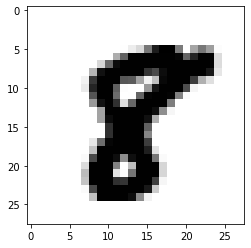

In [3]:
im = Image.open('mnist_train/1.png')
plt.imshow(im, cmap='binary')

In [4]:
import numpy as np

im_array = np.array(im)
print('Array Dimensions', im_array.shape)
print()
print(im_array)

Array Dimensions (28, 28)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1  18  38 136 227 255
  254 132   0  90 136  98   3   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  82 156 253 253 253 253 253
  253 249 154 219 253 253  35   0   0   0]
 [  0   0   0   0   0   0   0   0   0  40 150 244 253 253 253 253 253 253
  253 253 253 253 253 253  35   0   0   0]
 [  0   0   0   0   0   0   0   0  74

<br>
<br>
<br>

<br>
<br>
<br>

<br>
<br>
<br>

In [5]:
import pandas as pd

In [6]:
df_train = pd.read_csv('mnist_train.csv')
print(df_train.shape)
df_train.head()

(256, 2)


,Class Label,File Name
0,5,0.png
1,8,1.png
2,8,2.png
3,0,3.png
4,9,4.png


In [7]:
df_valid = pd.read_csv('mnist_valid.csv')
print(df_valid.shape)
df_valid.head()

(256, 2)


,Class Label,File Name
0,0,256.png
1,8,257.png
2,7,258.png
3,4,259.png
4,7,260.png


In [8]:
df_test = pd.read_csv('mnist_test.csv')
print(df_test.shape)
df_test.head()

(256, 2)


,Class Label,File Name
0,4,512.png
1,0,513.png
2,6,514.png
3,8,515.png
4,4,516.png


<br>
<br>
<br>

<br>
<br>
<br>

# 2) Custom Dataset Class

In [9]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import os



class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

<br>
<br>
<br>

<br>
<br>
<br>

# 3) Custom Dataloader

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader


# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
                                       transforms.ToTensor()
                                      ])

train_dataset = MyDataset(csv_path='mnist_train.csv',
                          img_dir='mnist_train',
                          transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

In [11]:
valid_dataset = MyDataset(csv_path='mnist_valid.csv',
                          img_dir='mnist_valid',
                          transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=100,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='mnist_test.csv',
                         img_dir='mnist_test',
                         transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=100,
                         shuffle=False,
                         num_workers=0)

<br>
<br>
<br>

## 4) Iterating Through the Dataset

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 1 | Batch index: 1 | Batch size: 32
Epoch: 1 | Batch index: 2 | Batch size: 32
Epoch: 1 | Batch index: 3 | Batch size: 32
Epoch: 1 | Batch index: 4 | Batch size: 32
Epoch: 1 | Batch index: 5 | Batch size: 32
Epoch: 1 | Batch index: 6 | Batch size: 32
Epoch: 1 | Batch index: 7 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 1 | Batch size: 32
Epoch: 2 | Batch index: 2 | Batch size: 32
Epoch: 2 | Batch index: 3 | Batch size: 32
Epoch: 2 | Batch index: 4 | Batch size: 32
Epoch: 2 | Batch index: 5 | Batch size: 32
Epoch: 2 | Batch index: 6 | Batch size: 32
Epoch: 2 | Batch index: 7 | Batch size: 32


In [13]:
print(x.shape)

torch.Size([32, 1, 28, 28])


In [14]:
x_image_as_vector = x.view(-1, 28*28)
print(x_image_as_vector.shape)

torch.Size([32, 784])


In [15]:
x

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.